# 训练
也可以直接加载模型，进行生成，代码说明博客 https://blog.csdn.net/zhaoguanghe/article/details/103937962

In [1]:
# tf2 生成手写体数字
import tensorflow as tf
from tensorflow.keras import layers

D:\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\tensorflow2\lib\site-packages\tensorflow\python\framework\dtypes.py:519: 

In [2]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

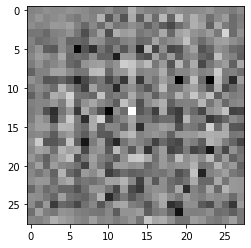

In [3]:
import matplotlib.pyplot as plt

generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [4]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [5]:
discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print(decision)

tf.Tensor([[0.00181567]], shape=(1, 1), dtype=float32)


In [6]:
# 该方法返回计算交叉熵损失的辅助函数
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# 该方法量化判别器从判断真伪图片的能力。它将判别器对真实图片的预测值与值全为 1 的数组进行对比，将判别器对伪造（生成的）图片的预测值与值全为 0 的数组进行对比。
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

# 生成器损失量化其欺骗判别器的能力。直观来讲，如果生成器表现良好，判别器将会把伪造图片判断为真实图片（或 1）。
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# 需要分别训练两个网络，判别器和生成器的优化器是不同的。
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [7]:
import os

checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [8]:
# 注意 `tf.function` 的使用，该注解使函数被“编译”
noise_dim = 100

@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss

In [9]:
# 准备数据
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalize the images to [-1, 1]

BUFFER_SIZE = 60000
BATCH_SIZE = 256

# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

11493376/11490434 [==============================] - 4s 0us/step


In [10]:
def generate_and_save_images(model, epoch, test_input):
    # 注意 training` 设定为 False
    # 因此，所有层都在推理模式下运行（batchnorm）
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./output/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

In [11]:
noise_dim = 100
num_examples_to_generate = 16

# 我们将重复使用该种子（因此在动画 GIF 中更容易可视化进度）
seed = tf.random.normal([num_examples_to_generate, noise_dim])

def train(dataset, epochs):
    #for epoch in range(epochs):
        #start = time.time()
    for epoch in range(epochs):
        for i,image_batch in enumerate(dataset):
            g,d = train_step(image_batch)
            print("batch %d, gen_loss %f,disc_loss %f" % (i, g.numpy(),d.numpy()))
            
        # 每 15 个 epoch 保存一次模型
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
            
    generate_and_save_images(generator,
                             epochs,
                             seed)
    
    # 保存模型
    generator.save('./mnist_dcgan_tf2.h5')

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
batch 0, gen_loss 0.682000,disc_loss 1.407749
batch 1, gen_loss 0.658952,disc_loss 1.363341
batch 2, gen_loss 0.642512,disc_loss 1.332992
batch 3, gen_loss 0.632731,disc_loss 1.305136
batch 4, gen_loss 0.621588,disc_loss 1.272942
batch 5, gen_loss 0.619702,disc_loss 1.241303
batch 6, gen_loss 0.611067,disc_loss 1.218733
batch 7, gen_loss 0.601644,disc_loss 1.197905
batch 8, gen_loss 0.594359,disc_loss 1.175442
batch 9, gen_loss 0.581817,disc_loss 1.158622
batch 10, gen_loss 0.566858,disc_loss 1.155433
batch 11, gen_loss 0.552755,disc_loss 1.145516
batch 12, gen_loss 0.531690,disc_loss 1.154317
batch 13, gen_loss 0.517233,disc_loss 1.158157
batch 14, gen_loss 0.494370,disc_loss 1.175368
batch 15, gen_loss 0.474825,disc_loss 1.188691
batch 16, gen_loss 0.455374,disc_loss 1.209649
batch 17, gen_loss 0.439874,disc_loss 1.223509
batch 18, gen_loss 0.426482,disc_loss 1.238348
batch 19, gen_loss 0.41

batch 114, gen_loss 0.581010,disc_loss 1.343316
batch 115, gen_loss 0.598153,disc_loss 1.306090
batch 116, gen_loss 0.606802,disc_loss 1.261147
batch 117, gen_loss 0.618112,disc_loss 1.247580
batch 118, gen_loss 0.620319,disc_loss 1.219843
batch 119, gen_loss 0.631564,disc_loss 1.193659
batch 120, gen_loss 0.645745,disc_loss 1.169697
batch 121, gen_loss 0.660228,disc_loss 1.133722
batch 122, gen_loss 0.676591,disc_loss 1.107792
batch 123, gen_loss 0.690102,disc_loss 1.078023
batch 124, gen_loss 0.710604,disc_loss 1.042835
batch 125, gen_loss 0.741711,disc_loss 1.005149
batch 126, gen_loss 0.755063,disc_loss 0.998846
batch 127, gen_loss 0.772168,disc_loss 0.995805
batch 128, gen_loss 0.803350,disc_loss 0.972200
batch 129, gen_loss 0.823106,disc_loss 0.940499
batch 130, gen_loss 0.830787,disc_loss 0.945237
batch 131, gen_loss 0.852170,disc_loss 0.931586
batch 132, gen_loss 0.865666,disc_loss 0.921660
batch 133, gen_loss 0.883418,disc_loss 0.923581
batch 134, gen_loss 0.876291,disc_loss 0

batch 34, gen_loss 0.525687,disc_loss 1.848444
batch 35, gen_loss 0.530794,disc_loss 1.829005
batch 36, gen_loss 0.517424,disc_loss 1.789244
batch 37, gen_loss 0.520386,disc_loss 1.789252
batch 38, gen_loss 0.517382,disc_loss 1.788372
batch 39, gen_loss 0.516101,disc_loss 1.783880
batch 40, gen_loss 0.511660,disc_loss 1.802928
batch 41, gen_loss 0.530308,disc_loss 1.789070
batch 42, gen_loss 0.529632,disc_loss 1.730753
batch 43, gen_loss 0.529631,disc_loss 1.685753
batch 44, gen_loss 0.543968,disc_loss 1.679492
batch 45, gen_loss 0.542891,disc_loss 1.658165
batch 46, gen_loss 0.555048,disc_loss 1.638174
batch 47, gen_loss 0.562858,disc_loss 1.565020
batch 48, gen_loss 0.581545,disc_loss 1.540811
batch 49, gen_loss 0.596899,disc_loss 1.512285
batch 50, gen_loss 0.603905,disc_loss 1.459261
batch 51, gen_loss 0.628497,disc_loss 1.403569
batch 52, gen_loss 0.656269,disc_loss 1.382360
batch 53, gen_loss 0.667552,disc_loss 1.344520
batch 54, gen_loss 0.696151,disc_loss 1.285750
batch 55, gen

batch 211, gen_loss 0.550120,disc_loss 1.619498
batch 212, gen_loss 0.572278,disc_loss 1.655935
batch 213, gen_loss 0.566832,disc_loss 1.631624
batch 214, gen_loss 0.598135,disc_loss 1.558746
batch 215, gen_loss 0.590791,disc_loss 1.515397
batch 216, gen_loss 0.606108,disc_loss 1.474284
batch 217, gen_loss 0.615983,disc_loss 1.465922
batch 218, gen_loss 0.639263,disc_loss 1.453619
batch 219, gen_loss 0.643888,disc_loss 1.432336
batch 220, gen_loss 0.647422,disc_loss 1.381673
batch 221, gen_loss 0.666253,disc_loss 1.308684
batch 222, gen_loss 0.681800,disc_loss 1.264966
batch 223, gen_loss 0.711636,disc_loss 1.247302
batch 224, gen_loss 0.730703,disc_loss 1.184464
batch 225, gen_loss 0.764199,disc_loss 1.147895
batch 226, gen_loss 0.808696,disc_loss 1.128359
batch 227, gen_loss 0.826185,disc_loss 1.083220
batch 228, gen_loss 0.870418,disc_loss 1.055745
batch 229, gen_loss 0.893455,disc_loss 1.050592
batch 230, gen_loss 0.902820,disc_loss 1.045779
batch 231, gen_loss 0.940533,disc_loss 0

batch 154, gen_loss 0.905239,disc_loss 1.058795
batch 155, gen_loss 0.924859,disc_loss 1.032113
batch 156, gen_loss 0.893577,disc_loss 1.039558
batch 157, gen_loss 0.851019,disc_loss 1.082942
batch 158, gen_loss 0.863325,disc_loss 1.075954
batch 159, gen_loss 0.864809,disc_loss 1.090655
batch 160, gen_loss 0.877918,disc_loss 1.112004
batch 161, gen_loss 0.847749,disc_loss 1.131220
batch 162, gen_loss 0.844570,disc_loss 1.133415
batch 163, gen_loss 0.858804,disc_loss 1.194913
batch 164, gen_loss 0.890166,disc_loss 1.132488
batch 165, gen_loss 0.858021,disc_loss 1.168453
batch 166, gen_loss 0.830815,disc_loss 1.184951
batch 167, gen_loss 0.846142,disc_loss 1.199985
batch 168, gen_loss 0.805119,disc_loss 1.200507
batch 169, gen_loss 0.814863,disc_loss 1.249953
batch 170, gen_loss 0.817567,disc_loss 1.248379
batch 171, gen_loss 0.862484,disc_loss 1.200101
batch 172, gen_loss 0.848748,disc_loss 1.222551
batch 173, gen_loss 0.854902,disc_loss 1.209291
batch 174, gen_loss 0.846800,disc_loss 1

batch 92, gen_loss 0.728816,disc_loss 1.611461
batch 93, gen_loss 0.720178,disc_loss 1.527785
batch 94, gen_loss 0.736259,disc_loss 1.561288
batch 95, gen_loss 0.748242,disc_loss 1.538140
batch 96, gen_loss 0.796869,disc_loss 1.589290
batch 97, gen_loss 0.786213,disc_loss 1.623446
batch 98, gen_loss 0.711769,disc_loss 1.567573
batch 99, gen_loss 0.703878,disc_loss 1.549146
batch 100, gen_loss 0.708831,disc_loss 1.531355
batch 101, gen_loss 0.763424,disc_loss 1.502916
batch 102, gen_loss 0.792636,disc_loss 1.503457
batch 103, gen_loss 0.796443,disc_loss 1.486175
batch 104, gen_loss 0.768480,disc_loss 1.458563
batch 105, gen_loss 0.777550,disc_loss 1.451077
batch 106, gen_loss 0.741612,disc_loss 1.450645
batch 107, gen_loss 0.772174,disc_loss 1.423883
batch 108, gen_loss 0.773061,disc_loss 1.356201
batch 109, gen_loss 0.845570,disc_loss 1.366669
batch 110, gen_loss 0.875181,disc_loss 1.320112
batch 111, gen_loss 0.885006,disc_loss 1.296450
batch 112, gen_loss 0.868162,disc_loss 1.324836


batch 31, gen_loss 0.854137,disc_loss 1.367645
batch 32, gen_loss 0.840497,disc_loss 1.381038
batch 33, gen_loss 0.849100,disc_loss 1.407142
batch 34, gen_loss 0.810618,disc_loss 1.365216
batch 35, gen_loss 0.821985,disc_loss 1.375413
batch 36, gen_loss 0.840520,disc_loss 1.370875
batch 37, gen_loss 0.846371,disc_loss 1.328752
batch 38, gen_loss 0.881652,disc_loss 1.320352
batch 39, gen_loss 0.845401,disc_loss 1.313204
batch 40, gen_loss 0.866244,disc_loss 1.303928
batch 41, gen_loss 0.878552,disc_loss 1.251433
batch 42, gen_loss 0.882564,disc_loss 1.226425
batch 43, gen_loss 0.935400,disc_loss 1.199313
batch 44, gen_loss 0.958889,disc_loss 1.186291
batch 45, gen_loss 0.972694,disc_loss 1.176484
batch 46, gen_loss 0.965801,disc_loss 1.150074
batch 47, gen_loss 0.946081,disc_loss 1.100313
batch 48, gen_loss 0.951051,disc_loss 1.103501
batch 49, gen_loss 0.979771,disc_loss 1.091179
batch 50, gen_loss 1.008945,disc_loss 1.080488
batch 51, gen_loss 1.036607,disc_loss 1.039828
batch 52, gen

batch 204, gen_loss 0.828898,disc_loss 1.278743
batch 205, gen_loss 0.821473,disc_loss 1.291961
batch 206, gen_loss 0.839733,disc_loss 1.293431
batch 207, gen_loss 0.832088,disc_loss 1.261123
batch 208, gen_loss 0.851688,disc_loss 1.297833
batch 209, gen_loss 0.807465,disc_loss 1.268625
batch 210, gen_loss 0.790449,disc_loss 1.320519
batch 211, gen_loss 0.807818,disc_loss 1.336417
batch 212, gen_loss 0.846415,disc_loss 1.299030
batch 213, gen_loss 0.816099,disc_loss 1.327053
batch 214, gen_loss 0.872608,disc_loss 1.254006
batch 215, gen_loss 0.817790,disc_loss 1.249268
batch 216, gen_loss 0.840134,disc_loss 1.239777
batch 217, gen_loss 0.914485,disc_loss 1.252766
batch 218, gen_loss 0.867110,disc_loss 1.319456
batch 219, gen_loss 0.910672,disc_loss 1.316075
batch 220, gen_loss 0.888139,disc_loss 1.309351
batch 221, gen_loss 0.844291,disc_loss 1.245877
batch 222, gen_loss 0.790937,disc_loss 1.296063
batch 223, gen_loss 0.835893,disc_loss 1.291982
batch 224, gen_loss 0.860196,disc_loss 1

batch 144, gen_loss 0.809793,disc_loss 1.219944
batch 145, gen_loss 0.872191,disc_loss 1.195388
batch 146, gen_loss 0.834214,disc_loss 1.194726
batch 147, gen_loss 0.878300,disc_loss 1.213256
batch 148, gen_loss 0.855550,disc_loss 1.204516
batch 149, gen_loss 0.852166,disc_loss 1.244898
batch 150, gen_loss 0.830411,disc_loss 1.249307
batch 151, gen_loss 0.838090,disc_loss 1.223560
batch 152, gen_loss 0.828374,disc_loss 1.207677
batch 153, gen_loss 0.804679,disc_loss 1.213539
batch 154, gen_loss 0.848588,disc_loss 1.202098
batch 155, gen_loss 0.912598,disc_loss 1.226687
batch 156, gen_loss 0.894414,disc_loss 1.235519
batch 157, gen_loss 0.848210,disc_loss 1.221439
batch 158, gen_loss 0.841042,disc_loss 1.237697
batch 159, gen_loss 0.795907,disc_loss 1.249498
batch 160, gen_loss 0.812255,disc_loss 1.213337
batch 161, gen_loss 0.826805,disc_loss 1.222918
batch 162, gen_loss 0.849223,disc_loss 1.252009
batch 163, gen_loss 0.881261,disc_loss 1.229892
batch 164, gen_loss 0.884562,disc_loss 1

batch 83, gen_loss 0.837903,disc_loss 1.356358
batch 84, gen_loss 0.786765,disc_loss 1.327979
batch 85, gen_loss 0.795095,disc_loss 1.331086
batch 86, gen_loss 0.793108,disc_loss 1.362108
batch 87, gen_loss 0.795086,disc_loss 1.385065
batch 88, gen_loss 0.774030,disc_loss 1.420878
batch 89, gen_loss 0.762755,disc_loss 1.434135
batch 90, gen_loss 0.789706,disc_loss 1.375723
batch 91, gen_loss 0.782595,disc_loss 1.467586
batch 92, gen_loss 0.795179,disc_loss 1.474046
batch 93, gen_loss 0.782309,disc_loss 1.419878
batch 94, gen_loss 0.741750,disc_loss 1.494314
batch 95, gen_loss 0.735960,disc_loss 1.485026
batch 96, gen_loss 0.736594,disc_loss 1.458620
batch 97, gen_loss 0.736734,disc_loss 1.535676
batch 98, gen_loss 0.719681,disc_loss 1.510605
batch 99, gen_loss 0.726231,disc_loss 1.494940
batch 100, gen_loss 0.779665,disc_loss 1.466077
batch 101, gen_loss 0.745609,disc_loss 1.495947
batch 102, gen_loss 0.713934,disc_loss 1.560103
batch 103, gen_loss 0.694900,disc_loss 1.525851
batch 104

batch 24, gen_loss 0.806944,disc_loss 1.368515
batch 25, gen_loss 0.820772,disc_loss 1.448696
batch 26, gen_loss 0.843534,disc_loss 1.358410
batch 27, gen_loss 0.835413,disc_loss 1.348585
batch 28, gen_loss 0.802943,disc_loss 1.388925
batch 29, gen_loss 0.800151,disc_loss 1.366228
batch 30, gen_loss 0.816567,disc_loss 1.287050
batch 31, gen_loss 0.857861,disc_loss 1.269538
batch 32, gen_loss 0.842535,disc_loss 1.336193
batch 33, gen_loss 0.856307,disc_loss 1.262568
batch 34, gen_loss 0.875095,disc_loss 1.311752
batch 35, gen_loss 0.839790,disc_loss 1.234646
batch 36, gen_loss 0.863133,disc_loss 1.248759
batch 37, gen_loss 0.903924,disc_loss 1.250067
batch 38, gen_loss 0.924311,disc_loss 1.209302
batch 39, gen_loss 0.916569,disc_loss 1.215129
batch 40, gen_loss 0.890965,disc_loss 1.203214
batch 41, gen_loss 0.883468,disc_loss 1.191886
batch 42, gen_loss 0.925259,disc_loss 1.144887
batch 43, gen_loss 0.929033,disc_loss 1.180772
batch 44, gen_loss 0.896072,disc_loss 1.176486
batch 45, gen

batch 201, gen_loss 0.687372,disc_loss 1.474882
batch 202, gen_loss 0.698688,disc_loss 1.452837
batch 203, gen_loss 0.714328,disc_loss 1.398559
batch 204, gen_loss 0.708078,disc_loss 1.426453
batch 205, gen_loss 0.744646,disc_loss 1.381171
batch 206, gen_loss 0.697229,disc_loss 1.410648
batch 207, gen_loss 0.725610,disc_loss 1.380577
batch 208, gen_loss 0.779005,disc_loss 1.388293
batch 209, gen_loss 0.738913,disc_loss 1.390870
batch 210, gen_loss 0.723886,disc_loss 1.383882
batch 211, gen_loss 0.745707,disc_loss 1.384922
batch 212, gen_loss 0.762630,disc_loss 1.330325
batch 213, gen_loss 0.767242,disc_loss 1.320261
batch 214, gen_loss 0.813691,disc_loss 1.271891
batch 215, gen_loss 0.816988,disc_loss 1.301830
batch 216, gen_loss 0.793189,disc_loss 1.342977
batch 217, gen_loss 0.770246,disc_loss 1.340979
batch 218, gen_loss 0.808781,disc_loss 1.270934
batch 219, gen_loss 0.811462,disc_loss 1.357378
batch 220, gen_loss 0.831728,disc_loss 1.304410
batch 221, gen_loss 0.802171,disc_loss 1

batch 141, gen_loss 0.771199,disc_loss 1.512469
batch 142, gen_loss 0.753307,disc_loss 1.539514
batch 143, gen_loss 0.775838,disc_loss 1.497922
batch 144, gen_loss 0.759056,disc_loss 1.545041
batch 145, gen_loss 0.758921,disc_loss 1.576302
batch 146, gen_loss 0.784475,disc_loss 1.495045
batch 147, gen_loss 0.832257,disc_loss 1.499566
batch 148, gen_loss 0.785531,disc_loss 1.463037
batch 149, gen_loss 0.841175,disc_loss 1.420674
batch 150, gen_loss 0.785377,disc_loss 1.419117
batch 151, gen_loss 0.835875,disc_loss 1.394818
batch 152, gen_loss 0.853829,disc_loss 1.368775
batch 153, gen_loss 0.856412,disc_loss 1.326647
batch 154, gen_loss 0.915369,disc_loss 1.333482
batch 155, gen_loss 0.886923,disc_loss 1.362090
batch 156, gen_loss 0.894274,disc_loss 1.217737
batch 157, gen_loss 0.933706,disc_loss 1.256509
batch 158, gen_loss 0.949722,disc_loss 1.279376
batch 159, gen_loss 0.991633,disc_loss 1.199022
batch 160, gen_loss 0.965449,disc_loss 1.179430
batch 161, gen_loss 0.989372,disc_loss 1

batch 85, gen_loss 0.937376,disc_loss 1.327598
batch 86, gen_loss 0.933978,disc_loss 1.297925
batch 87, gen_loss 0.950073,disc_loss 1.354622
batch 88, gen_loss 0.909584,disc_loss 1.340263
batch 89, gen_loss 0.884562,disc_loss 1.365389
batch 90, gen_loss 0.845603,disc_loss 1.308194
batch 91, gen_loss 0.829969,disc_loss 1.415204
batch 92, gen_loss 0.872336,disc_loss 1.397093
batch 93, gen_loss 0.886400,disc_loss 1.300730
batch 94, gen_loss 0.896812,disc_loss 1.303028
batch 95, gen_loss 0.917594,disc_loss 1.331900
batch 96, gen_loss 0.933120,disc_loss 1.332751
batch 97, gen_loss 0.872189,disc_loss 1.423896
batch 98, gen_loss 0.848218,disc_loss 1.311375
batch 99, gen_loss 0.861171,disc_loss 1.312939
batch 100, gen_loss 0.840529,disc_loss 1.309766
batch 101, gen_loss 0.859486,disc_loss 1.311262
batch 102, gen_loss 0.905488,disc_loss 1.259026
batch 103, gen_loss 0.921672,disc_loss 1.282715
batch 104, gen_loss 0.940252,disc_loss 1.247248
batch 105, gen_loss 0.939341,disc_loss 1.274158
batch 1

batch 25, gen_loss 0.913465,disc_loss 1.287914
batch 26, gen_loss 0.961465,disc_loss 1.223556
batch 27, gen_loss 0.964182,disc_loss 1.262219
batch 28, gen_loss 0.941782,disc_loss 1.256636
batch 29, gen_loss 0.945661,disc_loss 1.156869
batch 30, gen_loss 0.919384,disc_loss 1.139878
batch 31, gen_loss 0.944941,disc_loss 1.161063
batch 32, gen_loss 0.972382,disc_loss 1.194394
batch 33, gen_loss 0.997148,disc_loss 1.116392
batch 34, gen_loss 1.032562,disc_loss 1.142735
batch 35, gen_loss 1.041774,disc_loss 1.100521
batch 36, gen_loss 1.040178,disc_loss 1.104090
batch 37, gen_loss 0.985773,disc_loss 1.096227
batch 38, gen_loss 0.999420,disc_loss 1.111998
batch 39, gen_loss 1.018257,disc_loss 1.077874
batch 40, gen_loss 1.013215,disc_loss 1.043166
batch 41, gen_loss 1.071863,disc_loss 1.029438
batch 42, gen_loss 1.128301,disc_loss 1.011849
batch 43, gen_loss 1.138307,disc_loss 1.038592
batch 44, gen_loss 1.094607,disc_loss 0.996895
batch 45, gen_loss 1.099474,disc_loss 1.020239
batch 46, gen

batch 199, gen_loss 0.836401,disc_loss 1.300628
batch 200, gen_loss 0.875366,disc_loss 1.292857
batch 201, gen_loss 0.907433,disc_loss 1.282386
batch 202, gen_loss 0.901931,disc_loss 1.294019
batch 203, gen_loss 0.888293,disc_loss 1.315218
batch 204, gen_loss 0.848176,disc_loss 1.324852
batch 205, gen_loss 0.820161,disc_loss 1.305742
batch 206, gen_loss 0.862031,disc_loss 1.280850
batch 207, gen_loss 0.878628,disc_loss 1.356195
batch 208, gen_loss 0.857489,disc_loss 1.308070
batch 209, gen_loss 0.801402,disc_loss 1.348772
batch 210, gen_loss 0.853865,disc_loss 1.337642
batch 211, gen_loss 0.854563,disc_loss 1.323743
batch 212, gen_loss 0.819649,disc_loss 1.316837
batch 213, gen_loss 0.852924,disc_loss 1.291808
batch 214, gen_loss 0.881650,disc_loss 1.299736
batch 215, gen_loss 0.873045,disc_loss 1.309795
batch 216, gen_loss 0.799934,disc_loss 1.315291
batch 217, gen_loss 0.829910,disc_loss 1.316362
batch 218, gen_loss 0.838299,disc_loss 1.294572
batch 219, gen_loss 0.860463,disc_loss 1

batch 142, gen_loss 0.871423,disc_loss 1.319824
batch 143, gen_loss 0.871098,disc_loss 1.321698
batch 144, gen_loss 0.876314,disc_loss 1.328620
batch 145, gen_loss 0.899999,disc_loss 1.320601
batch 146, gen_loss 0.885950,disc_loss 1.268367
batch 147, gen_loss 0.917738,disc_loss 1.298507
batch 148, gen_loss 0.890183,disc_loss 1.299754
batch 149, gen_loss 0.854357,disc_loss 1.280805
batch 150, gen_loss 0.857462,disc_loss 1.242058
batch 151, gen_loss 0.895662,disc_loss 1.202046
batch 152, gen_loss 0.921970,disc_loss 1.258146
batch 153, gen_loss 0.939989,disc_loss 1.213506
batch 154, gen_loss 0.973559,disc_loss 1.216428
batch 155, gen_loss 0.904070,disc_loss 1.189289
batch 156, gen_loss 0.904995,disc_loss 1.192092
batch 157, gen_loss 0.904062,disc_loss 1.208964
batch 158, gen_loss 0.933112,disc_loss 1.171808
batch 159, gen_loss 0.979057,disc_loss 1.159096
batch 160, gen_loss 1.064464,disc_loss 1.132343
batch 161, gen_loss 0.980964,disc_loss 1.118801
batch 162, gen_loss 0.951232,disc_loss 1

batch 85, gen_loss 1.139766,disc_loss 0.989438
batch 86, gen_loss 1.114214,disc_loss 0.998168
batch 87, gen_loss 1.121842,disc_loss 0.949387
batch 88, gen_loss 1.127634,disc_loss 1.000414
batch 89, gen_loss 1.071492,disc_loss 1.015247
batch 90, gen_loss 1.110582,disc_loss 0.954059
batch 91, gen_loss 1.053641,disc_loss 1.033831
batch 92, gen_loss 1.135308,disc_loss 1.011401
batch 93, gen_loss 1.124210,disc_loss 1.021934
batch 94, gen_loss 1.060647,disc_loss 1.046091
batch 95, gen_loss 1.009161,disc_loss 1.068122
batch 96, gen_loss 0.988325,disc_loss 1.087883
batch 97, gen_loss 1.031959,disc_loss 1.060904
batch 98, gen_loss 1.040162,disc_loss 1.058389
batch 99, gen_loss 1.059067,disc_loss 1.028623
batch 100, gen_loss 1.089949,disc_loss 1.064755
batch 101, gen_loss 1.081372,disc_loss 1.153907
batch 102, gen_loss 1.008160,disc_loss 1.083693
batch 103, gen_loss 0.922312,disc_loss 1.131999
batch 104, gen_loss 0.883618,disc_loss 1.150195
batch 105, gen_loss 0.956182,disc_loss 1.146310
batch 1

batch 24, gen_loss 1.111957,disc_loss 1.072911
batch 25, gen_loss 1.134270,disc_loss 1.074084
batch 26, gen_loss 1.072362,disc_loss 1.042881
batch 27, gen_loss 1.082792,disc_loss 1.024347
batch 28, gen_loss 1.035711,disc_loss 1.079369
batch 29, gen_loss 1.022377,disc_loss 1.065899
batch 30, gen_loss 1.087757,disc_loss 1.015213
batch 31, gen_loss 1.120215,disc_loss 1.043511
batch 32, gen_loss 1.144980,disc_loss 1.076809
batch 33, gen_loss 1.120817,disc_loss 0.973601
batch 34, gen_loss 1.032180,disc_loss 1.042215
batch 35, gen_loss 1.074251,disc_loss 0.946947
batch 36, gen_loss 1.088515,disc_loss 0.962249
batch 37, gen_loss 1.221637,disc_loss 0.963922
batch 38, gen_loss 1.181040,disc_loss 0.963826
batch 39, gen_loss 1.200422,disc_loss 0.941881
batch 40, gen_loss 1.223707,disc_loss 0.920471
batch 41, gen_loss 1.193264,disc_loss 0.911284
batch 42, gen_loss 1.117192,disc_loss 0.929267
batch 43, gen_loss 1.132190,disc_loss 0.910504
batch 44, gen_loss 1.185503,disc_loss 0.902813
batch 45, gen

batch 202, gen_loss 1.281784,disc_loss 0.965138
batch 203, gen_loss 1.062161,disc_loss 0.982237
batch 204, gen_loss 1.034723,disc_loss 0.955898
batch 205, gen_loss 1.087974,disc_loss 1.009671
batch 206, gen_loss 1.191169,disc_loss 0.952091
batch 207, gen_loss 1.367490,disc_loss 0.864711
batch 208, gen_loss 1.315743,disc_loss 1.007271
batch 209, gen_loss 1.231080,disc_loss 0.921769
batch 210, gen_loss 1.004850,disc_loss 1.006407
batch 211, gen_loss 1.064063,disc_loss 0.944536
batch 212, gen_loss 1.238860,disc_loss 0.969422
batch 213, gen_loss 1.385665,disc_loss 0.913925
batch 214, gen_loss 1.392917,disc_loss 0.937825
batch 215, gen_loss 1.238704,disc_loss 0.986563
batch 216, gen_loss 1.244684,disc_loss 0.900148
batch 217, gen_loss 1.136416,disc_loss 1.000373
batch 218, gen_loss 1.218823,disc_loss 0.987740
batch 219, gen_loss 1.189108,disc_loss 0.980377
batch 220, gen_loss 1.203488,disc_loss 0.956491
batch 221, gen_loss 1.153938,disc_loss 1.017731
batch 222, gen_loss 1.213993,disc_loss 1

batch 144, gen_loss 1.049659,disc_loss 1.070782
batch 145, gen_loss 1.114116,disc_loss 1.034758
batch 146, gen_loss 1.187349,disc_loss 1.047617
batch 147, gen_loss 1.198201,disc_loss 1.070813
batch 148, gen_loss 1.241208,disc_loss 1.080998
batch 149, gen_loss 1.246791,disc_loss 0.973655
batch 150, gen_loss 1.197698,disc_loss 1.076164
batch 151, gen_loss 1.091809,disc_loss 1.081286
batch 152, gen_loss 1.033682,disc_loss 1.135278
batch 153, gen_loss 1.066204,disc_loss 1.066794
batch 154, gen_loss 1.123993,disc_loss 1.169784
batch 155, gen_loss 1.144774,disc_loss 1.189939
batch 156, gen_loss 1.124759,disc_loss 1.128129
batch 157, gen_loss 1.170901,disc_loss 1.150414
batch 158, gen_loss 1.120988,disc_loss 1.158772
batch 159, gen_loss 1.041947,disc_loss 1.128115
batch 160, gen_loss 1.048302,disc_loss 1.137954
batch 161, gen_loss 1.028046,disc_loss 1.142139
batch 162, gen_loss 1.074284,disc_loss 1.096056
batch 163, gen_loss 1.097759,disc_loss 1.141537
batch 164, gen_loss 1.169311,disc_loss 1

batch 85, gen_loss 1.018589,disc_loss 1.173980
batch 86, gen_loss 0.956528,disc_loss 1.190152
batch 87, gen_loss 0.884285,disc_loss 1.187607
batch 88, gen_loss 1.019443,disc_loss 1.135193
batch 89, gen_loss 1.063341,disc_loss 1.199557
batch 90, gen_loss 1.073964,disc_loss 1.101210
batch 91, gen_loss 1.119665,disc_loss 1.050617
batch 92, gen_loss 1.102703,disc_loss 1.083625
batch 93, gen_loss 1.055497,disc_loss 1.103006
batch 94, gen_loss 1.021258,disc_loss 1.114604
batch 95, gen_loss 1.026264,disc_loss 1.121846
batch 96, gen_loss 0.996324,disc_loss 1.134806
batch 97, gen_loss 1.059859,disc_loss 1.086117
batch 98, gen_loss 1.095845,disc_loss 1.085634
batch 99, gen_loss 1.060173,disc_loss 1.112512
batch 100, gen_loss 1.139510,disc_loss 1.068059
batch 101, gen_loss 1.103988,disc_loss 1.163598
batch 102, gen_loss 1.109481,disc_loss 1.063403
batch 103, gen_loss 1.054158,disc_loss 1.091070
batch 104, gen_loss 1.001866,disc_loss 1.089549
batch 105, gen_loss 1.023200,disc_loss 1.092336
batch 1

batch 24, gen_loss 1.231662,disc_loss 0.952421
batch 25, gen_loss 1.183970,disc_loss 0.898815
batch 26, gen_loss 1.189610,disc_loss 0.895471
batch 27, gen_loss 1.239525,disc_loss 0.927757
batch 28, gen_loss 1.211975,disc_loss 0.975296
batch 29, gen_loss 1.192776,disc_loss 0.965701
batch 30, gen_loss 1.053682,disc_loss 0.979863
batch 31, gen_loss 1.092219,disc_loss 0.953500
batch 32, gen_loss 1.093168,disc_loss 0.980733
batch 33, gen_loss 1.180473,disc_loss 0.938332
batch 34, gen_loss 1.201581,disc_loss 0.966658
batch 35, gen_loss 1.212730,disc_loss 1.012458
batch 36, gen_loss 1.098693,disc_loss 0.965969
batch 37, gen_loss 1.104040,disc_loss 1.059088
batch 38, gen_loss 1.012922,disc_loss 1.014387
batch 39, gen_loss 1.089266,disc_loss 1.015970
batch 40, gen_loss 1.094884,disc_loss 0.960170
batch 41, gen_loss 1.190318,disc_loss 0.972893
batch 42, gen_loss 1.183311,disc_loss 0.997727
batch 43, gen_loss 1.150918,disc_loss 1.023971
batch 44, gen_loss 1.111357,disc_loss 0.998001
batch 45, gen

batch 197, gen_loss 1.273233,disc_loss 1.206536
batch 198, gen_loss 1.184471,disc_loss 1.334283
batch 199, gen_loss 1.003932,disc_loss 1.257402
batch 200, gen_loss 0.971398,disc_loss 1.302381
batch 201, gen_loss 1.174119,disc_loss 1.342401
batch 202, gen_loss 1.351306,disc_loss 1.262383
batch 203, gen_loss 1.187585,disc_loss 1.220646
batch 204, gen_loss 1.098460,disc_loss 1.257180
batch 205, gen_loss 1.027080,disc_loss 1.197453
batch 206, gen_loss 1.056527,disc_loss 1.238791
batch 207, gen_loss 1.234648,disc_loss 1.214085
batch 208, gen_loss 1.407100,disc_loss 1.186066
batch 209, gen_loss 1.230020,disc_loss 1.150759
batch 210, gen_loss 1.108220,disc_loss 1.144705
batch 211, gen_loss 1.050078,disc_loss 1.208856
batch 212, gen_loss 1.130908,disc_loss 1.134159
batch 213, gen_loss 1.242127,disc_loss 1.126002
batch 214, gen_loss 1.362921,disc_loss 1.094602
batch 215, gen_loss 1.214554,disc_loss 0.970539
batch 216, gen_loss 1.131320,disc_loss 1.050564
batch 217, gen_loss 1.076203,disc_loss 1

batch 137, gen_loss 1.001514,disc_loss 1.041397
batch 138, gen_loss 1.168801,disc_loss 0.984997
batch 139, gen_loss 1.259445,disc_loss 0.989899
batch 140, gen_loss 1.208676,disc_loss 1.030971
batch 141, gen_loss 1.064431,disc_loss 1.004878
batch 142, gen_loss 0.959728,disc_loss 1.043781
batch 143, gen_loss 0.970748,disc_loss 0.999353
batch 144, gen_loss 1.100311,disc_loss 0.981079
batch 145, gen_loss 1.251079,disc_loss 0.941574
batch 146, gen_loss 1.279978,disc_loss 0.948084
batch 147, gen_loss 1.255804,disc_loss 1.001461
batch 148, gen_loss 1.194506,disc_loss 0.943332
batch 149, gen_loss 1.037359,disc_loss 0.958960
batch 150, gen_loss 1.045971,disc_loss 0.952382
batch 151, gen_loss 1.066401,disc_loss 0.968292
batch 152, gen_loss 1.096013,disc_loss 0.967579
batch 153, gen_loss 1.267336,disc_loss 0.931446
batch 154, gen_loss 1.347338,disc_loss 1.012099
batch 155, gen_loss 1.206957,disc_loss 1.052348
batch 156, gen_loss 1.135926,disc_loss 0.978217
batch 157, gen_loss 1.018643,disc_loss 1

batch 78, gen_loss 1.401351,disc_loss 0.852883
batch 79, gen_loss 1.459999,disc_loss 0.744798
batch 80, gen_loss 1.521987,disc_loss 0.826522
batch 81, gen_loss 1.408457,disc_loss 0.834363
batch 82, gen_loss 1.464569,disc_loss 0.833778
batch 83, gen_loss 1.367241,disc_loss 0.801527
batch 84, gen_loss 1.438832,disc_loss 0.840920
batch 85, gen_loss 1.487132,disc_loss 0.858855
batch 86, gen_loss 1.419297,disc_loss 0.860010
batch 87, gen_loss 1.355531,disc_loss 0.831661
batch 88, gen_loss 1.279075,disc_loss 0.902335
batch 89, gen_loss 1.396177,disc_loss 0.932520
batch 90, gen_loss 1.428754,disc_loss 0.917040
batch 91, gen_loss 1.374910,disc_loss 0.868216
batch 92, gen_loss 1.306196,disc_loss 0.939398
batch 93, gen_loss 1.193033,disc_loss 1.008676
batch 94, gen_loss 1.168182,disc_loss 1.062689
batch 95, gen_loss 1.161977,disc_loss 1.071954
batch 96, gen_loss 1.150421,disc_loss 1.143949
batch 97, gen_loss 1.065688,disc_loss 1.092439
batch 98, gen_loss 1.181248,disc_loss 1.064167
batch 99, gen

batch 18, gen_loss 1.125788,disc_loss 1.133647
batch 19, gen_loss 1.149115,disc_loss 1.106392
batch 20, gen_loss 1.091856,disc_loss 1.095250
batch 21, gen_loss 1.022215,disc_loss 1.201304
batch 22, gen_loss 1.033733,disc_loss 1.038928
batch 23, gen_loss 1.005318,disc_loss 1.133499
batch 24, gen_loss 1.014403,disc_loss 1.120301
batch 25, gen_loss 1.147369,disc_loss 1.141149
batch 26, gen_loss 1.070014,disc_loss 1.154203
batch 27, gen_loss 1.133096,disc_loss 1.102606
batch 28, gen_loss 1.054589,disc_loss 1.184568
batch 29, gen_loss 0.978849,disc_loss 1.163917
batch 30, gen_loss 0.998659,disc_loss 1.106358
batch 31, gen_loss 1.039340,disc_loss 1.170427
batch 32, gen_loss 1.022477,disc_loss 1.221899
batch 33, gen_loss 1.091132,disc_loss 1.247208
batch 34, gen_loss 1.049675,disc_loss 1.235605
batch 35, gen_loss 1.039656,disc_loss 1.110367
batch 36, gen_loss 0.983276,disc_loss 1.186094
batch 37, gen_loss 1.037859,disc_loss 1.246408
batch 38, gen_loss 0.955445,disc_loss 1.256500
batch 39, gen

batch 196, gen_loss 1.285979,disc_loss 1.015373
batch 197, gen_loss 1.243498,disc_loss 0.992522
batch 198, gen_loss 1.202763,disc_loss 0.956267
batch 199, gen_loss 1.163734,disc_loss 1.015249
batch 200, gen_loss 1.180147,disc_loss 0.946322
batch 201, gen_loss 1.182997,disc_loss 1.047726
batch 202, gen_loss 1.351748,disc_loss 0.950988
batch 203, gen_loss 1.319767,disc_loss 1.013690
batch 204, gen_loss 1.229943,disc_loss 1.005776
batch 205, gen_loss 1.110920,disc_loss 1.112452
batch 206, gen_loss 1.070266,disc_loss 1.109965
batch 207, gen_loss 1.162851,disc_loss 1.094259
batch 208, gen_loss 1.206028,disc_loss 1.114819
batch 209, gen_loss 1.146421,disc_loss 1.147619
batch 210, gen_loss 1.145710,disc_loss 1.016569
batch 211, gen_loss 1.117427,disc_loss 1.165416
batch 212, gen_loss 1.146525,disc_loss 1.096254
batch 213, gen_loss 1.102394,disc_loss 1.154054
batch 214, gen_loss 1.127143,disc_loss 1.065248
batch 215, gen_loss 1.108119,disc_loss 1.059385
batch 216, gen_loss 1.100577,disc_loss 1

batch 137, gen_loss 1.400162,disc_loss 0.914337
batch 138, gen_loss 1.253354,disc_loss 0.891037
batch 139, gen_loss 1.176403,disc_loss 0.896712
batch 140, gen_loss 1.301810,disc_loss 0.870127
batch 141, gen_loss 1.405710,disc_loss 0.828563
batch 142, gen_loss 1.385720,disc_loss 0.900938
batch 143, gen_loss 1.315321,disc_loss 0.908059
batch 144, gen_loss 1.320843,disc_loss 0.815917
batch 145, gen_loss 1.294763,disc_loss 0.882041
batch 146, gen_loss 1.358982,disc_loss 0.856154
batch 147, gen_loss 1.327948,disc_loss 0.875463
batch 148, gen_loss 1.338878,disc_loss 0.973503
batch 149, gen_loss 1.284402,disc_loss 0.859890
batch 150, gen_loss 1.219484,disc_loss 1.020867
batch 151, gen_loss 1.222629,disc_loss 0.942725
batch 152, gen_loss 1.308213,disc_loss 0.919138
batch 153, gen_loss 1.147803,disc_loss 0.887140
batch 154, gen_loss 1.221604,disc_loss 0.888329
batch 155, gen_loss 1.341448,disc_loss 0.933900
batch 156, gen_loss 1.403010,disc_loss 0.960935
batch 157, gen_loss 1.272267,disc_loss 0

batch 77, gen_loss 1.207245,disc_loss 1.291227
batch 78, gen_loss 1.240304,disc_loss 1.100924
batch 79, gen_loss 1.172078,disc_loss 1.211310
batch 80, gen_loss 1.187662,disc_loss 1.195382
batch 81, gen_loss 1.098210,disc_loss 1.209812
batch 82, gen_loss 1.176218,disc_loss 1.155062
batch 83, gen_loss 1.216784,disc_loss 1.269769
batch 84, gen_loss 1.180392,disc_loss 1.225618
batch 85, gen_loss 1.188039,disc_loss 1.213415
batch 86, gen_loss 1.075366,disc_loss 1.282121
batch 87, gen_loss 1.126069,disc_loss 1.141880
batch 88, gen_loss 1.192908,disc_loss 1.189983
batch 89, gen_loss 1.218903,disc_loss 1.201698
batch 90, gen_loss 1.273775,disc_loss 1.090272
batch 91, gen_loss 1.136607,disc_loss 1.289713
batch 92, gen_loss 1.131051,disc_loss 1.194174
batch 93, gen_loss 1.165751,disc_loss 1.099260
batch 94, gen_loss 1.321398,disc_loss 1.039857
batch 95, gen_loss 1.161580,disc_loss 1.157010
batch 96, gen_loss 1.212564,disc_loss 1.086830
batch 97, gen_loss 1.259374,disc_loss 1.092926
batch 98, gen

batch 18, gen_loss 1.387113,disc_loss 0.960542
batch 19, gen_loss 1.256619,disc_loss 0.919463
batch 20, gen_loss 1.277087,disc_loss 0.944055
batch 21, gen_loss 1.344067,disc_loss 0.987178
batch 22, gen_loss 1.413842,disc_loss 0.950291
batch 23, gen_loss 1.322263,disc_loss 0.940901
batch 24, gen_loss 1.391101,disc_loss 0.865973
batch 25, gen_loss 1.332174,disc_loss 0.914504
batch 26, gen_loss 1.363816,disc_loss 0.926583
batch 27, gen_loss 1.437898,disc_loss 0.916443
batch 28, gen_loss 1.338825,disc_loss 0.994566
batch 29, gen_loss 1.329964,disc_loss 0.984877
batch 30, gen_loss 1.324532,disc_loss 0.923599
batch 31, gen_loss 1.252415,disc_loss 0.982362
batch 32, gen_loss 1.190421,disc_loss 1.014020
batch 33, gen_loss 1.254343,disc_loss 0.963135
batch 34, gen_loss 1.278627,disc_loss 1.035280
batch 35, gen_loss 1.255002,disc_loss 0.996578
batch 36, gen_loss 1.412146,disc_loss 0.921160
batch 37, gen_loss 1.411524,disc_loss 0.961223
batch 38, gen_loss 1.212773,disc_loss 1.018574
batch 39, gen

batch 191, gen_loss 0.990423,disc_loss 1.247801
batch 192, gen_loss 0.967372,disc_loss 1.270710
batch 193, gen_loss 1.166224,disc_loss 1.154009
batch 194, gen_loss 1.329518,disc_loss 1.305739
batch 195, gen_loss 1.166943,disc_loss 1.285673
batch 196, gen_loss 0.995940,disc_loss 1.293865
batch 197, gen_loss 0.968367,disc_loss 1.312807
batch 198, gen_loss 1.044182,disc_loss 1.232051
batch 199, gen_loss 1.201487,disc_loss 1.174181
batch 200, gen_loss 1.227436,disc_loss 1.223439
batch 201, gen_loss 1.123845,disc_loss 1.332021
batch 202, gen_loss 1.136336,disc_loss 1.163229
batch 203, gen_loss 1.062472,disc_loss 1.173098
batch 204, gen_loss 1.011949,disc_loss 1.212809
batch 205, gen_loss 1.156240,disc_loss 1.198705
batch 206, gen_loss 1.335954,disc_loss 1.108867
batch 207, gen_loss 1.284524,disc_loss 1.156705
batch 208, gen_loss 1.175604,disc_loss 1.125166
batch 209, gen_loss 1.055701,disc_loss 1.106151
batch 210, gen_loss 1.112785,disc_loss 1.085249
batch 211, gen_loss 1.230035,disc_loss 1

batch 132, gen_loss 1.250853,disc_loss 0.975197
batch 133, gen_loss 1.372794,disc_loss 0.859340
batch 134, gen_loss 1.335578,disc_loss 0.934166
batch 135, gen_loss 1.217939,disc_loss 0.985587
batch 136, gen_loss 1.253799,disc_loss 0.955934
batch 137, gen_loss 1.283178,disc_loss 0.950287
batch 138, gen_loss 1.224904,disc_loss 0.943857
batch 139, gen_loss 1.251055,disc_loss 0.950741
batch 140, gen_loss 1.406182,disc_loss 0.979666
batch 141, gen_loss 1.324578,disc_loss 0.990556
batch 142, gen_loss 1.282543,disc_loss 1.015501
batch 143, gen_loss 1.120756,disc_loss 0.974321
batch 144, gen_loss 1.196429,disc_loss 0.985086
batch 145, gen_loss 1.112169,disc_loss 1.065103
batch 146, gen_loss 1.289617,disc_loss 0.999246
batch 147, gen_loss 1.314786,disc_loss 1.026555
batch 148, gen_loss 1.306806,disc_loss 1.110702
batch 149, gen_loss 1.237411,disc_loss 0.976345
batch 150, gen_loss 1.111516,disc_loss 1.081604
batch 151, gen_loss 1.008376,disc_loss 1.078270
batch 152, gen_loss 1.105390,disc_loss 1

batch 71, gen_loss 1.021453,disc_loss 1.123901
batch 72, gen_loss 1.116110,disc_loss 1.118376
batch 73, gen_loss 1.319355,disc_loss 1.227674
batch 74, gen_loss 1.173876,disc_loss 1.205732
batch 75, gen_loss 1.112221,disc_loss 1.206235
batch 76, gen_loss 1.099151,disc_loss 1.138012
batch 77, gen_loss 1.108587,disc_loss 1.209256
batch 78, gen_loss 1.093415,disc_loss 1.131134
batch 79, gen_loss 1.125846,disc_loss 1.182062
batch 80, gen_loss 1.171496,disc_loss 1.167769
batch 81, gen_loss 1.177398,disc_loss 1.247520
batch 82, gen_loss 1.088001,disc_loss 1.191526
batch 83, gen_loss 1.138192,disc_loss 1.186649
batch 84, gen_loss 1.103759,disc_loss 1.135935
batch 85, gen_loss 1.081801,disc_loss 1.190119
batch 86, gen_loss 1.170101,disc_loss 1.189708
batch 87, gen_loss 1.180251,disc_loss 1.135107
batch 88, gen_loss 1.104182,disc_loss 1.161774
batch 89, gen_loss 1.165111,disc_loss 1.144271
batch 90, gen_loss 1.178016,disc_loss 1.104913
batch 91, gen_loss 1.031794,disc_loss 1.272869
batch 92, gen

batch 12, gen_loss 1.137981,disc_loss 1.139988
batch 13, gen_loss 1.059006,disc_loss 1.177026
batch 14, gen_loss 0.987175,disc_loss 1.276121
batch 15, gen_loss 1.082624,disc_loss 1.246841
batch 16, gen_loss 1.180229,disc_loss 1.224724
batch 17, gen_loss 1.140174,disc_loss 1.219460
batch 18, gen_loss 1.056501,disc_loss 1.281538
batch 19, gen_loss 1.005464,disc_loss 1.269710
batch 20, gen_loss 0.962187,disc_loss 1.212892
batch 21, gen_loss 1.149937,disc_loss 1.296020
batch 22, gen_loss 1.120138,disc_loss 1.274472
batch 23, gen_loss 1.061531,disc_loss 1.216776
batch 24, gen_loss 1.008303,disc_loss 1.227070
batch 25, gen_loss 1.030988,disc_loss 1.361938
batch 26, gen_loss 1.147170,disc_loss 1.239301
batch 27, gen_loss 1.213107,disc_loss 1.248943
batch 28, gen_loss 1.086038,disc_loss 1.319216
batch 29, gen_loss 0.916752,disc_loss 1.259558
batch 30, gen_loss 0.904230,disc_loss 1.273517
batch 31, gen_loss 1.101888,disc_loss 1.253595
batch 32, gen_loss 1.155231,disc_loss 1.271337
batch 33, gen

batch 186, gen_loss 0.969784,disc_loss 1.211421
batch 187, gen_loss 0.990797,disc_loss 1.239845
batch 188, gen_loss 1.000260,disc_loss 1.230530
batch 189, gen_loss 1.061931,disc_loss 1.196345
batch 190, gen_loss 1.075110,disc_loss 1.306766
batch 191, gen_loss 1.009587,disc_loss 1.248783
batch 192, gen_loss 1.047403,disc_loss 1.233401
batch 193, gen_loss 1.095006,disc_loss 1.268746
batch 194, gen_loss 1.043590,disc_loss 1.172584
batch 195, gen_loss 1.109086,disc_loss 1.291034
batch 196, gen_loss 1.110972,disc_loss 1.276448
batch 197, gen_loss 0.997923,disc_loss 1.264851
batch 198, gen_loss 0.936971,disc_loss 1.242048
batch 199, gen_loss 0.981382,disc_loss 1.275790
batch 200, gen_loss 1.244939,disc_loss 1.137946
batch 201, gen_loss 1.186315,disc_loss 1.185770
batch 202, gen_loss 1.152024,disc_loss 1.199922
batch 203, gen_loss 0.975892,disc_loss 1.236924
batch 204, gen_loss 0.894982,disc_loss 1.255728
batch 205, gen_loss 0.993039,disc_loss 1.226165
batch 206, gen_loss 0.995259,disc_loss 1

batch 125, gen_loss 1.305664,disc_loss 0.911101
batch 126, gen_loss 1.304688,disc_loss 0.952299
batch 127, gen_loss 1.442470,disc_loss 0.891686
batch 128, gen_loss 1.271953,disc_loss 0.907438
batch 129, gen_loss 1.384165,disc_loss 0.923984
batch 130, gen_loss 1.437330,disc_loss 0.861245
batch 131, gen_loss 1.360167,disc_loss 0.909135
batch 132, gen_loss 1.369150,disc_loss 0.900109
batch 133, gen_loss 1.298009,disc_loss 0.869838
batch 134, gen_loss 1.288927,disc_loss 0.932660
batch 135, gen_loss 1.384571,disc_loss 0.914228
batch 136, gen_loss 1.435751,disc_loss 0.874590
batch 137, gen_loss 1.508832,disc_loss 0.854084
batch 138, gen_loss 1.495937,disc_loss 0.836617
batch 139, gen_loss 1.363205,disc_loss 0.848506
batch 140, gen_loss 1.340641,disc_loss 0.853296
batch 141, gen_loss 1.384069,disc_loss 0.812044
batch 142, gen_loss 1.519558,disc_loss 0.837315
batch 143, gen_loss 1.583203,disc_loss 0.835329
batch 144, gen_loss 1.560652,disc_loss 0.797212
batch 145, gen_loss 1.443847,disc_loss 0

batch 68, gen_loss 1.321768,disc_loss 0.964879
batch 69, gen_loss 1.290517,disc_loss 0.910120
batch 70, gen_loss 1.286003,disc_loss 0.933931
batch 71, gen_loss 1.353921,disc_loss 0.889881
batch 72, gen_loss 1.609199,disc_loss 0.854394
batch 73, gen_loss 1.505321,disc_loss 0.923872
batch 74, gen_loss 1.400674,disc_loss 0.998298
batch 75, gen_loss 1.339175,disc_loss 0.871933
batch 76, gen_loss 1.149752,disc_loss 0.991932
batch 77, gen_loss 1.359734,disc_loss 0.949084
batch 78, gen_loss 1.431399,disc_loss 0.971241
batch 79, gen_loss 1.394264,disc_loss 1.004867
batch 80, gen_loss 1.445848,disc_loss 0.916303
batch 81, gen_loss 1.382480,disc_loss 0.988527
batch 82, gen_loss 1.324079,disc_loss 0.993597
batch 83, gen_loss 1.266621,disc_loss 1.047278
batch 84, gen_loss 1.341283,disc_loss 0.948703
batch 85, gen_loss 1.412648,disc_loss 0.956533
batch 86, gen_loss 1.305328,disc_loss 1.018785
batch 87, gen_loss 1.450699,disc_loss 0.884164
batch 88, gen_loss 1.315072,disc_loss 1.083324
batch 89, gen

batch 8, gen_loss 1.529051,disc_loss 0.950235
batch 9, gen_loss 1.327271,disc_loss 0.963400
batch 10, gen_loss 1.236284,disc_loss 0.972079
batch 11, gen_loss 1.229731,disc_loss 1.017504
batch 12, gen_loss 1.328715,disc_loss 0.977829
batch 13, gen_loss 1.351105,disc_loss 0.964156
batch 14, gen_loss 1.370938,disc_loss 0.985026
batch 15, gen_loss 1.272365,disc_loss 1.106098
batch 16, gen_loss 1.436979,disc_loss 0.976115
batch 17, gen_loss 1.170252,disc_loss 1.046995
batch 18, gen_loss 1.235116,disc_loss 1.089496
batch 19, gen_loss 1.201386,disc_loss 1.078002
batch 20, gen_loss 1.223181,disc_loss 1.091413
batch 21, gen_loss 1.300795,disc_loss 1.138842
batch 22, gen_loss 1.326082,disc_loss 1.050750
batch 23, gen_loss 1.159692,disc_loss 1.080404
batch 24, gen_loss 1.196129,disc_loss 1.089990
batch 25, gen_loss 1.230177,disc_loss 1.059787
batch 26, gen_loss 1.130934,disc_loss 1.061385
batch 27, gen_loss 1.223404,disc_loss 1.079309
batch 28, gen_loss 1.277555,disc_loss 1.133856
batch 29, gen_l

batch 188, gen_loss 1.161250,disc_loss 1.255157
batch 189, gen_loss 1.057734,disc_loss 1.135059
batch 190, gen_loss 1.122480,disc_loss 1.089137
batch 191, gen_loss 1.092379,disc_loss 1.145211
batch 192, gen_loss 1.207115,disc_loss 1.255404
batch 193, gen_loss 1.153268,disc_loss 1.142504
batch 194, gen_loss 1.112684,disc_loss 1.095761
batch 195, gen_loss 1.106747,disc_loss 1.172709
batch 196, gen_loss 1.088747,disc_loss 1.169216
batch 197, gen_loss 1.152279,disc_loss 1.121819
batch 198, gen_loss 1.039125,disc_loss 1.232078
batch 199, gen_loss 1.141222,disc_loss 1.087610
batch 200, gen_loss 1.112794,disc_loss 1.137711
batch 201, gen_loss 1.116800,disc_loss 1.102038
batch 202, gen_loss 1.147908,disc_loss 1.156784
batch 203, gen_loss 1.032160,disc_loss 1.139730
batch 204, gen_loss 1.092359,disc_loss 1.106569
batch 205, gen_loss 1.268805,disc_loss 1.045714
batch 206, gen_loss 1.104564,disc_loss 1.114683
batch 207, gen_loss 1.168502,disc_loss 1.129835
batch 208, gen_loss 1.159506,disc_loss 1

batch 131, gen_loss 1.207795,disc_loss 1.052614
batch 132, gen_loss 1.076567,disc_loss 1.147533
batch 133, gen_loss 1.073496,disc_loss 1.119300
batch 134, gen_loss 0.956714,disc_loss 1.166004
batch 135, gen_loss 0.992933,disc_loss 1.162670
batch 136, gen_loss 1.158788,disc_loss 1.149988
batch 137, gen_loss 1.244262,disc_loss 1.161179
batch 138, gen_loss 1.135582,disc_loss 1.155373
batch 139, gen_loss 1.004529,disc_loss 1.132046
batch 140, gen_loss 1.000920,disc_loss 1.132205
batch 141, gen_loss 1.114449,disc_loss 1.059761
batch 142, gen_loss 1.045232,disc_loss 1.168014
batch 143, gen_loss 1.184177,disc_loss 1.135620
batch 144, gen_loss 1.241195,disc_loss 1.054854
batch 145, gen_loss 1.182801,disc_loss 1.064429
batch 146, gen_loss 1.090687,disc_loss 1.161420
batch 147, gen_loss 1.153572,disc_loss 1.153214
batch 148, gen_loss 1.002777,disc_loss 1.154515
batch 149, gen_loss 1.003786,disc_loss 1.137941
batch 150, gen_loss 1.142805,disc_loss 1.117212
batch 151, gen_loss 1.185706,disc_loss 1

batch 72, gen_loss 1.081978,disc_loss 1.142181
batch 73, gen_loss 1.008556,disc_loss 1.173638
batch 74, gen_loss 1.137114,disc_loss 1.237956
batch 75, gen_loss 1.056777,disc_loss 1.210481
batch 76, gen_loss 1.132846,disc_loss 1.191515
batch 77, gen_loss 1.109408,disc_loss 1.204256
batch 78, gen_loss 1.086330,disc_loss 1.135022
batch 79, gen_loss 1.015143,disc_loss 1.104274
batch 80, gen_loss 1.049111,disc_loss 1.153637
batch 81, gen_loss 1.166378,disc_loss 1.124394
batch 82, gen_loss 1.199684,disc_loss 1.224447
batch 83, gen_loss 1.106486,disc_loss 1.114679
batch 84, gen_loss 1.094021,disc_loss 1.122301
batch 85, gen_loss 1.051416,disc_loss 1.160010
batch 86, gen_loss 1.082460,disc_loss 1.170147
batch 87, gen_loss 1.150668,disc_loss 1.090444
batch 88, gen_loss 1.129981,disc_loss 1.188830
batch 89, gen_loss 1.165518,disc_loss 1.152279
batch 90, gen_loss 1.037015,disc_loss 1.163406
batch 91, gen_loss 1.001429,disc_loss 1.169736
batch 92, gen_loss 1.086021,disc_loss 1.178454
batch 93, gen

batch 12, gen_loss 1.064568,disc_loss 1.237521
batch 13, gen_loss 1.054974,disc_loss 1.266595
batch 14, gen_loss 0.957868,disc_loss 1.234572
batch 15, gen_loss 0.936852,disc_loss 1.162802
batch 16, gen_loss 0.992348,disc_loss 1.175903
batch 17, gen_loss 1.151140,disc_loss 1.099125
batch 18, gen_loss 1.076987,disc_loss 1.207594
batch 19, gen_loss 1.050911,disc_loss 1.247394
batch 20, gen_loss 1.072645,disc_loss 1.202178
batch 21, gen_loss 0.990364,disc_loss 1.274354
batch 22, gen_loss 0.976169,disc_loss 1.120050
batch 23, gen_loss 0.938221,disc_loss 1.260087
batch 24, gen_loss 1.113959,disc_loss 1.139158
batch 25, gen_loss 1.117815,disc_loss 1.218863
batch 26, gen_loss 1.135702,disc_loss 1.191566
batch 27, gen_loss 1.054883,disc_loss 1.289777
batch 28, gen_loss 0.975066,disc_loss 1.256041
batch 29, gen_loss 0.983428,disc_loss 1.193328
batch 30, gen_loss 1.014319,disc_loss 1.179623
batch 31, gen_loss 1.048516,disc_loss 1.286926
batch 32, gen_loss 1.036467,disc_loss 1.234951
batch 33, gen

batch 186, gen_loss 1.064995,disc_loss 1.191542
batch 187, gen_loss 1.042919,disc_loss 1.178538
batch 188, gen_loss 0.999063,disc_loss 1.197078
batch 189, gen_loss 0.992166,disc_loss 1.152350
batch 190, gen_loss 1.076456,disc_loss 1.184114
batch 191, gen_loss 1.033573,disc_loss 1.148881
batch 192, gen_loss 1.100710,disc_loss 1.189286
batch 193, gen_loss 1.081675,disc_loss 1.160632
batch 194, gen_loss 1.005943,disc_loss 1.262337
batch 195, gen_loss 0.958943,disc_loss 1.201635
batch 196, gen_loss 0.937669,disc_loss 1.248025
batch 197, gen_loss 1.024794,disc_loss 1.242078
batch 198, gen_loss 1.074015,disc_loss 1.234620
batch 199, gen_loss 1.025670,disc_loss 1.208419
batch 200, gen_loss 1.094040,disc_loss 1.163606
batch 201, gen_loss 1.003963,disc_loss 1.218568
batch 202, gen_loss 0.931673,disc_loss 1.249807
batch 203, gen_loss 0.965989,disc_loss 1.307169
batch 204, gen_loss 1.082467,disc_loss 1.190781
batch 205, gen_loss 1.050038,disc_loss 1.219216
batch 206, gen_loss 1.037044,disc_loss 1

batch 126, gen_loss 0.923794,disc_loss 1.363009
batch 127, gen_loss 0.895840,disc_loss 1.295699
batch 128, gen_loss 0.914192,disc_loss 1.391529
batch 129, gen_loss 0.977516,disc_loss 1.331139
batch 130, gen_loss 0.930088,disc_loss 1.315739
batch 131, gen_loss 0.986522,disc_loss 1.280009
batch 132, gen_loss 0.940821,disc_loss 1.377658
batch 133, gen_loss 0.928774,disc_loss 1.381493
batch 134, gen_loss 0.861200,disc_loss 1.367754
batch 135, gen_loss 0.934276,disc_loss 1.328408
batch 136, gen_loss 0.955368,disc_loss 1.314402
batch 137, gen_loss 0.936342,disc_loss 1.339706
batch 138, gen_loss 1.040564,disc_loss 1.251670
batch 139, gen_loss 0.966630,disc_loss 1.223683
batch 140, gen_loss 0.966565,disc_loss 1.299415
batch 141, gen_loss 0.961448,disc_loss 1.308784
batch 142, gen_loss 1.016523,disc_loss 1.336893
batch 143, gen_loss 0.954884,disc_loss 1.311893
batch 144, gen_loss 0.925837,disc_loss 1.355148
batch 145, gen_loss 0.920268,disc_loss 1.263858
batch 146, gen_loss 0.927244,disc_loss 1

batch 65, gen_loss 1.283004,disc_loss 1.074651
batch 66, gen_loss 1.181957,disc_loss 1.082839
batch 67, gen_loss 1.069227,disc_loss 1.088276
batch 68, gen_loss 0.969621,disc_loss 1.116903
batch 69, gen_loss 0.978380,disc_loss 1.089040
batch 70, gen_loss 1.011425,disc_loss 1.198027
batch 71, gen_loss 1.231941,disc_loss 1.036453
batch 72, gen_loss 1.250167,disc_loss 1.098061
batch 73, gen_loss 1.163427,disc_loss 1.114865
batch 74, gen_loss 1.126674,disc_loss 1.153636
batch 75, gen_loss 0.931364,disc_loss 1.173604
batch 76, gen_loss 0.907470,disc_loss 1.177909
batch 77, gen_loss 1.002446,disc_loss 1.263862
batch 78, gen_loss 1.047866,disc_loss 1.193008
batch 79, gen_loss 1.160448,disc_loss 1.202638
batch 80, gen_loss 1.079454,disc_loss 1.226928
batch 81, gen_loss 1.010734,disc_loss 1.278700
batch 82, gen_loss 0.970083,disc_loss 1.212775
batch 83, gen_loss 0.918189,disc_loss 1.263128
batch 84, gen_loss 1.003749,disc_loss 1.315527
batch 85, gen_loss 1.060045,disc_loss 1.266142
batch 86, gen

batch 6, gen_loss 0.887514,disc_loss 1.318030
batch 7, gen_loss 0.989774,disc_loss 1.276980
batch 8, gen_loss 1.080745,disc_loss 1.267953
batch 9, gen_loss 1.132320,disc_loss 1.288224
batch 10, gen_loss 1.000666,disc_loss 1.275353
batch 11, gen_loss 0.922887,disc_loss 1.278816
batch 12, gen_loss 0.900683,disc_loss 1.337152
batch 13, gen_loss 0.914161,disc_loss 1.324839
batch 14, gen_loss 1.013961,disc_loss 1.328807
batch 15, gen_loss 1.020181,disc_loss 1.321681
batch 16, gen_loss 0.985019,disc_loss 1.253411
batch 17, gen_loss 0.972594,disc_loss 1.221492
batch 18, gen_loss 0.891715,disc_loss 1.332570
batch 19, gen_loss 0.965682,disc_loss 1.285384
batch 20, gen_loss 1.026058,disc_loss 1.270393
batch 21, gen_loss 0.973108,disc_loss 1.253514
batch 22, gen_loss 1.023665,disc_loss 1.249270
batch 23, gen_loss 0.944351,disc_loss 1.328295
batch 24, gen_loss 0.898088,disc_loss 1.251063
batch 25, gen_loss 0.987077,disc_loss 1.307855
batch 26, gen_loss 0.965336,disc_loss 1.278650
batch 27, gen_los

batch 179, gen_loss 1.148861,disc_loss 1.030250
batch 180, gen_loss 1.156781,disc_loss 1.037560
batch 181, gen_loss 1.062503,disc_loss 1.026033
batch 182, gen_loss 1.179332,disc_loss 1.018357
batch 183, gen_loss 1.158754,disc_loss 1.005963
batch 184, gen_loss 1.136030,disc_loss 1.050990
batch 185, gen_loss 1.133383,disc_loss 0.995310
batch 186, gen_loss 1.144273,disc_loss 0.991603
batch 187, gen_loss 1.145805,disc_loss 1.020358
batch 188, gen_loss 1.102120,disc_loss 1.001910
batch 189, gen_loss 1.205983,disc_loss 0.975384
batch 190, gen_loss 1.135627,disc_loss 1.042862
batch 191, gen_loss 1.223460,disc_loss 0.996110
batch 192, gen_loss 1.122533,disc_loss 1.025743
batch 193, gen_loss 1.140715,disc_loss 0.987870
batch 194, gen_loss 1.098882,disc_loss 1.027437
batch 195, gen_loss 1.126812,disc_loss 1.007259
batch 196, gen_loss 1.076736,disc_loss 1.054325
batch 197, gen_loss 1.195402,disc_loss 1.069077
batch 198, gen_loss 1.329326,disc_loss 1.045026
batch 199, gen_loss 1.216243,disc_loss 1

batch 121, gen_loss 1.090859,disc_loss 1.203165
batch 122, gen_loss 1.095796,disc_loss 1.196850
batch 123, gen_loss 1.029974,disc_loss 1.315294
batch 124, gen_loss 1.044168,disc_loss 1.205959
batch 125, gen_loss 1.029593,disc_loss 1.245438
batch 126, gen_loss 1.024247,disc_loss 1.212316
batch 127, gen_loss 1.012280,disc_loss 1.266971
batch 128, gen_loss 1.055159,disc_loss 1.255586
batch 129, gen_loss 1.054474,disc_loss 1.269132
batch 130, gen_loss 1.026409,disc_loss 1.262751
batch 131, gen_loss 0.993368,disc_loss 1.271824
batch 132, gen_loss 0.991785,disc_loss 1.252123
batch 133, gen_loss 0.941542,disc_loss 1.233073
batch 134, gen_loss 0.979988,disc_loss 1.238540
batch 135, gen_loss 0.999038,disc_loss 1.217215
batch 136, gen_loss 1.065253,disc_loss 1.192116
batch 137, gen_loss 1.094062,disc_loss 1.272736
batch 138, gen_loss 0.996878,disc_loss 1.220777
batch 139, gen_loss 0.965180,disc_loss 1.215160
batch 140, gen_loss 0.952307,disc_loss 1.306852
batch 141, gen_loss 0.990864,disc_loss 1

batch 60, gen_loss 0.975316,disc_loss 1.325168
batch 61, gen_loss 0.996079,disc_loss 1.299639
batch 62, gen_loss 1.026822,disc_loss 1.303361
batch 63, gen_loss 0.962037,disc_loss 1.327340
batch 64, gen_loss 0.963400,disc_loss 1.278373
batch 65, gen_loss 0.931048,disc_loss 1.277839
batch 66, gen_loss 1.029077,disc_loss 1.225605
batch 67, gen_loss 1.065705,disc_loss 1.221811
batch 68, gen_loss 1.029985,disc_loss 1.243767
batch 69, gen_loss 0.932419,disc_loss 1.197519
batch 70, gen_loss 1.022814,disc_loss 1.172230
batch 71, gen_loss 1.043203,disc_loss 1.176071
batch 72, gen_loss 1.004166,disc_loss 1.168777
batch 73, gen_loss 1.075384,disc_loss 1.190211
batch 74, gen_loss 1.024105,disc_loss 1.214694
batch 75, gen_loss 0.996192,disc_loss 1.159828
batch 76, gen_loss 0.991040,disc_loss 1.171062
batch 77, gen_loss 1.082507,disc_loss 1.152757
batch 78, gen_loss 1.036095,disc_loss 1.161996
batch 79, gen_loss 1.011089,disc_loss 1.206973
batch 80, gen_loss 1.005375,disc_loss 1.177188
batch 81, gen

batch 232, gen_loss 0.974150,disc_loss 1.207894
batch 233, gen_loss 0.846744,disc_loss 1.311596
batch 234, gen_loss 0.949353,disc_loss 1.212615
batch 0, gen_loss 1.022309,disc_loss 1.222778
batch 1, gen_loss 1.068089,disc_loss 1.239656
batch 2, gen_loss 1.057660,disc_loss 1.248584
batch 3, gen_loss 0.980071,disc_loss 1.191132
batch 4, gen_loss 0.955134,disc_loss 1.205921
batch 5, gen_loss 0.925645,disc_loss 1.203978
batch 6, gen_loss 1.010551,disc_loss 1.163041
batch 7, gen_loss 1.097835,disc_loss 1.129499
batch 8, gen_loss 1.093114,disc_loss 1.200727
batch 9, gen_loss 1.089886,disc_loss 1.138390
batch 10, gen_loss 0.893643,disc_loss 1.138428
batch 11, gen_loss 1.038535,disc_loss 1.107413
batch 12, gen_loss 0.995867,disc_loss 1.176931
batch 13, gen_loss 1.125528,disc_loss 1.109084
batch 14, gen_loss 1.049393,disc_loss 1.187857
batch 15, gen_loss 1.027420,disc_loss 1.151469
batch 16, gen_loss 0.982678,disc_loss 1.160426
batch 17, gen_loss 0.994281,disc_loss 1.132588
batch 18, gen_loss 1

batch 173, gen_loss 1.070032,disc_loss 1.137039
batch 174, gen_loss 0.955703,disc_loss 1.188391
batch 175, gen_loss 0.884618,disc_loss 1.194022
batch 176, gen_loss 0.897591,disc_loss 1.203537
batch 177, gen_loss 1.064272,disc_loss 1.204705
batch 178, gen_loss 1.109514,disc_loss 1.228604
batch 179, gen_loss 1.159751,disc_loss 1.156077
batch 180, gen_loss 1.012191,disc_loss 1.196502
batch 181, gen_loss 0.937468,disc_loss 1.209140
batch 182, gen_loss 0.924114,disc_loss 1.141430
batch 183, gen_loss 0.992616,disc_loss 1.181932
batch 184, gen_loss 1.032481,disc_loss 1.228428
batch 185, gen_loss 1.094003,disc_loss 1.187896
batch 186, gen_loss 1.006140,disc_loss 1.131701
batch 187, gen_loss 0.996729,disc_loss 1.182389
batch 188, gen_loss 1.003976,disc_loss 1.148799
batch 189, gen_loss 0.927020,disc_loss 1.209271
batch 190, gen_loss 0.906928,disc_loss 1.197101
batch 191, gen_loss 0.955323,disc_loss 1.190759
batch 192, gen_loss 1.028495,disc_loss 1.229463
batch 193, gen_loss 0.982674,disc_loss 1

batch 115, gen_loss 1.027630,disc_loss 1.218849
batch 116, gen_loss 0.975071,disc_loss 1.240627
batch 117, gen_loss 0.897245,disc_loss 1.239334
batch 118, gen_loss 0.919558,disc_loss 1.195072
batch 119, gen_loss 0.949622,disc_loss 1.223763
batch 120, gen_loss 0.997797,disc_loss 1.219390
batch 121, gen_loss 1.034033,disc_loss 1.220965
batch 122, gen_loss 0.977763,disc_loss 1.189761
batch 123, gen_loss 0.904464,disc_loss 1.273909
batch 124, gen_loss 0.894380,disc_loss 1.278231
batch 125, gen_loss 0.964100,disc_loss 1.216116
batch 126, gen_loss 0.915408,disc_loss 1.300114
batch 127, gen_loss 1.012467,disc_loss 1.184990
batch 128, gen_loss 0.952828,disc_loss 1.267437
batch 129, gen_loss 0.935330,disc_loss 1.209597
batch 130, gen_loss 0.915120,disc_loss 1.282130
batch 131, gen_loss 0.846891,disc_loss 1.296012
batch 132, gen_loss 0.872235,disc_loss 1.293277
batch 133, gen_loss 0.894369,disc_loss 1.286623
batch 134, gen_loss 0.905296,disc_loss 1.317448
batch 135, gen_loss 0.954921,disc_loss 1

batch 55, gen_loss 0.971108,disc_loss 1.205923
batch 56, gen_loss 0.905834,disc_loss 1.274456
batch 57, gen_loss 0.959253,disc_loss 1.194052
batch 58, gen_loss 0.970775,disc_loss 1.203688
batch 59, gen_loss 0.968237,disc_loss 1.294973
batch 60, gen_loss 0.954873,disc_loss 1.242901
batch 61, gen_loss 0.945058,disc_loss 1.218315
batch 62, gen_loss 0.901505,disc_loss 1.224490
batch 63, gen_loss 0.893548,disc_loss 1.257699
batch 64, gen_loss 0.971510,disc_loss 1.182258
batch 65, gen_loss 0.965820,disc_loss 1.247631
batch 66, gen_loss 0.954600,disc_loss 1.244366
batch 67, gen_loss 0.984807,disc_loss 1.214832
batch 68, gen_loss 0.954276,disc_loss 1.252181
batch 69, gen_loss 0.913349,disc_loss 1.227657
batch 70, gen_loss 0.855389,disc_loss 1.304532
batch 71, gen_loss 0.889865,disc_loss 1.299875
batch 72, gen_loss 0.893197,disc_loss 1.271482
batch 73, gen_loss 0.950727,disc_loss 1.257534
batch 74, gen_loss 0.905783,disc_loss 1.273176
batch 75, gen_loss 0.917784,disc_loss 1.267016
batch 76, gen

batch 229, gen_loss 0.994130,disc_loss 1.214560
batch 230, gen_loss 1.087284,disc_loss 1.204795
batch 231, gen_loss 1.030494,disc_loss 1.215999
batch 232, gen_loss 0.892849,disc_loss 1.224021
batch 233, gen_loss 0.915523,disc_loss 1.132203
batch 234, gen_loss 0.841146,disc_loss 1.228823
batch 0, gen_loss 0.884920,disc_loss 1.278991
batch 1, gen_loss 1.005235,disc_loss 1.165308
batch 2, gen_loss 1.065616,disc_loss 1.240697
batch 3, gen_loss 1.034621,disc_loss 1.170348
batch 4, gen_loss 0.906711,disc_loss 1.229976
batch 5, gen_loss 0.860339,disc_loss 1.224615
batch 6, gen_loss 0.823270,disc_loss 1.237626
batch 7, gen_loss 0.895091,disc_loss 1.217939
batch 8, gen_loss 1.025158,disc_loss 1.248058
batch 9, gen_loss 1.107616,disc_loss 1.145103
batch 10, gen_loss 1.000411,disc_loss 1.163715
batch 11, gen_loss 0.932815,disc_loss 1.187431
batch 12, gen_loss 0.838790,disc_loss 1.235250
batch 13, gen_loss 0.831055,disc_loss 1.219269
batch 14, gen_loss 0.928441,disc_loss 1.166690
batch 15, gen_los

batch 168, gen_loss 0.891213,disc_loss 1.303253
batch 169, gen_loss 0.929844,disc_loss 1.240016
batch 170, gen_loss 0.878514,disc_loss 1.237660
batch 171, gen_loss 0.808209,disc_loss 1.386084
batch 172, gen_loss 0.867737,disc_loss 1.257251
batch 173, gen_loss 0.876861,disc_loss 1.352500
batch 174, gen_loss 0.856083,disc_loss 1.342052
batch 175, gen_loss 0.876976,disc_loss 1.282444
batch 176, gen_loss 0.845318,disc_loss 1.287777
batch 177, gen_loss 0.947256,disc_loss 1.232038
batch 178, gen_loss 0.939377,disc_loss 1.291359
batch 179, gen_loss 0.808291,disc_loss 1.346982
batch 180, gen_loss 0.860885,disc_loss 1.298821
batch 181, gen_loss 0.900642,disc_loss 1.322062
batch 182, gen_loss 0.861490,disc_loss 1.267817
batch 183, gen_loss 0.878670,disc_loss 1.227161
batch 184, gen_loss 0.888901,disc_loss 1.319000
batch 185, gen_loss 0.954080,disc_loss 1.241538
batch 186, gen_loss 0.956670,disc_loss 1.191033
batch 187, gen_loss 1.007815,disc_loss 1.108670
batch 188, gen_loss 0.956283,disc_loss 1

batch 107, gen_loss 1.098190,disc_loss 1.326379
batch 108, gen_loss 1.063958,disc_loss 1.268909
batch 109, gen_loss 0.900092,disc_loss 1.392724
batch 110, gen_loss 0.769520,disc_loss 1.466923
batch 111, gen_loss 0.763250,disc_loss 1.396570
batch 112, gen_loss 0.844828,disc_loss 1.420865
batch 113, gen_loss 0.884022,disc_loss 1.369053
batch 114, gen_loss 0.924055,disc_loss 1.415978
batch 115, gen_loss 0.967380,disc_loss 1.382746
batch 116, gen_loss 0.927383,disc_loss 1.490906
batch 117, gen_loss 0.790321,disc_loss 1.470726
batch 118, gen_loss 0.729403,disc_loss 1.413678
batch 119, gen_loss 0.676194,disc_loss 1.480294
batch 120, gen_loss 0.754857,disc_loss 1.443880
batch 121, gen_loss 0.793770,disc_loss 1.388174
batch 122, gen_loss 0.883964,disc_loss 1.494403
batch 123, gen_loss 0.920653,disc_loss 1.386760
batch 124, gen_loss 0.854378,disc_loss 1.431959
batch 125, gen_loss 0.806732,disc_loss 1.372231
batch 126, gen_loss 0.789451,disc_loss 1.332223
batch 127, gen_loss 0.849799,disc_loss 1

batch 47, gen_loss 1.031817,disc_loss 1.175337
batch 48, gen_loss 1.048850,disc_loss 1.179984
batch 49, gen_loss 1.068937,disc_loss 1.086975
batch 50, gen_loss 1.157453,disc_loss 1.075902
batch 51, gen_loss 1.178677,disc_loss 1.065509
batch 52, gen_loss 1.120703,disc_loss 1.073265
batch 53, gen_loss 1.125814,disc_loss 1.059137
batch 54, gen_loss 1.070238,disc_loss 1.058147
batch 55, gen_loss 1.094550,disc_loss 1.068619
batch 56, gen_loss 1.070403,disc_loss 1.081586
batch 57, gen_loss 1.190206,disc_loss 1.055920
batch 58, gen_loss 1.293774,disc_loss 1.021064
batch 59, gen_loss 1.200670,disc_loss 1.082963
batch 60, gen_loss 1.110704,disc_loss 1.104153
batch 61, gen_loss 0.963640,disc_loss 1.102322
batch 62, gen_loss 0.981891,disc_loss 1.086275
batch 63, gen_loss 1.082857,disc_loss 1.066269
batch 64, gen_loss 1.158544,disc_loss 1.194925
batch 65, gen_loss 1.222252,disc_loss 1.086091
batch 66, gen_loss 1.149387,disc_loss 1.182133
batch 67, gen_loss 0.999885,disc_loss 1.199241
batch 68, gen

batch 222, gen_loss 1.077302,disc_loss 1.131083
batch 223, gen_loss 0.981628,disc_loss 1.202695
batch 224, gen_loss 0.944855,disc_loss 1.258831
batch 225, gen_loss 0.995511,disc_loss 1.244441
batch 226, gen_loss 1.018425,disc_loss 1.277165
batch 227, gen_loss 0.988842,disc_loss 1.309757
batch 228, gen_loss 0.951317,disc_loss 1.452687
batch 229, gen_loss 0.949281,disc_loss 1.352536
batch 230, gen_loss 0.987575,disc_loss 1.330977
batch 231, gen_loss 0.921339,disc_loss 1.311590
batch 232, gen_loss 0.903983,disc_loss 1.282160
batch 233, gen_loss 0.930590,disc_loss 1.352689
batch 234, gen_loss 1.036230,disc_loss 1.243105
batch 0, gen_loss 1.028314,disc_loss 1.286126
batch 1, gen_loss 0.977996,disc_loss 1.274931
batch 2, gen_loss 0.999514,disc_loss 1.261687
batch 3, gen_loss 0.959845,disc_loss 1.253967
batch 4, gen_loss 0.935114,disc_loss 1.281411
batch 5, gen_loss 0.955449,disc_loss 1.223163
batch 6, gen_loss 1.040865,disc_loss 1.177401
batch 7, gen_loss 0.990441,disc_loss 1.245849
batch 8,

batch 160, gen_loss 0.928826,disc_loss 1.194579
batch 161, gen_loss 0.974353,disc_loss 1.125284
batch 162, gen_loss 0.972814,disc_loss 1.157673
batch 163, gen_loss 0.968743,disc_loss 1.177844
batch 164, gen_loss 0.959198,disc_loss 1.077441
batch 165, gen_loss 0.962563,disc_loss 1.102162
batch 166, gen_loss 0.936776,disc_loss 1.146019
batch 167, gen_loss 0.944167,disc_loss 1.095037
batch 168, gen_loss 0.991104,disc_loss 1.070719
batch 169, gen_loss 1.006719,disc_loss 1.089331
batch 170, gen_loss 1.087582,disc_loss 1.097930
batch 171, gen_loss 1.090572,disc_loss 1.086664
batch 172, gen_loss 1.057742,disc_loss 1.088241
batch 173, gen_loss 0.932378,disc_loss 1.123183
batch 174, gen_loss 0.989118,disc_loss 1.074105
batch 175, gen_loss 0.998687,disc_loss 1.129721
batch 176, gen_loss 1.020394,disc_loss 1.123215
batch 177, gen_loss 1.020539,disc_loss 1.174109
batch 178, gen_loss 1.108510,disc_loss 1.112988
batch 179, gen_loss 1.065687,disc_loss 1.116589
batch 180, gen_loss 1.066028,disc_loss 1

batch 100, gen_loss 0.937554,disc_loss 1.338892
batch 101, gen_loss 0.924366,disc_loss 1.332538
batch 102, gen_loss 0.889063,disc_loss 1.328645
batch 103, gen_loss 0.858450,disc_loss 1.315210
batch 104, gen_loss 0.768278,disc_loss 1.400020
batch 105, gen_loss 0.747954,disc_loss 1.440320
batch 106, gen_loss 0.749534,disc_loss 1.380128
batch 107, gen_loss 0.811551,disc_loss 1.399594
batch 108, gen_loss 0.835022,disc_loss 1.356967
batch 109, gen_loss 0.859477,disc_loss 1.383208
batch 110, gen_loss 0.884948,disc_loss 1.386895
batch 111, gen_loss 0.836312,disc_loss 1.381608
batch 112, gen_loss 0.770737,disc_loss 1.367237
batch 113, gen_loss 0.762770,disc_loss 1.328853
batch 114, gen_loss 0.773868,disc_loss 1.357173
batch 115, gen_loss 0.851545,disc_loss 1.311195
batch 116, gen_loss 0.854962,disc_loss 1.359827
batch 117, gen_loss 0.873778,disc_loss 1.397148
batch 118, gen_loss 0.807048,disc_loss 1.346733
batch 119, gen_loss 0.783764,disc_loss 1.316578
batch 120, gen_loss 0.804228,disc_loss 1

batch 37, gen_loss 0.973213,disc_loss 1.260453
batch 38, gen_loss 0.959390,disc_loss 1.262182
batch 39, gen_loss 0.941320,disc_loss 1.267164
batch 40, gen_loss 0.957723,disc_loss 1.228915
batch 41, gen_loss 0.900522,disc_loss 1.287831
batch 42, gen_loss 0.958320,disc_loss 1.231347
batch 43, gen_loss 1.018227,disc_loss 1.191222
batch 44, gen_loss 0.989173,disc_loss 1.281302
batch 45, gen_loss 0.937816,disc_loss 1.194313
batch 46, gen_loss 0.948189,disc_loss 1.237933
batch 47, gen_loss 0.953136,disc_loss 1.238493
batch 48, gen_loss 0.925610,disc_loss 1.213239
batch 49, gen_loss 0.942392,disc_loss 1.228382
batch 50, gen_loss 0.931868,disc_loss 1.236603
batch 51, gen_loss 0.925098,disc_loss 1.250859
batch 52, gen_loss 0.967905,disc_loss 1.254680
batch 53, gen_loss 0.955510,disc_loss 1.207073
batch 54, gen_loss 0.948656,disc_loss 1.196756
batch 55, gen_loss 0.908975,disc_loss 1.241436
batch 56, gen_loss 0.895047,disc_loss 1.223066
batch 57, gen_loss 0.932689,disc_loss 1.218188
batch 58, gen

batch 214, gen_loss 0.994803,disc_loss 1.227260
batch 215, gen_loss 0.923469,disc_loss 1.294587
batch 216, gen_loss 0.928026,disc_loss 1.296358
batch 217, gen_loss 0.946225,disc_loss 1.255801
batch 218, gen_loss 0.922037,disc_loss 1.309760
batch 219, gen_loss 0.945539,disc_loss 1.359212
batch 220, gen_loss 0.969846,disc_loss 1.278740
batch 221, gen_loss 0.970142,disc_loss 1.304506
batch 222, gen_loss 0.916995,disc_loss 1.280702
batch 223, gen_loss 0.928983,disc_loss 1.333314
batch 224, gen_loss 0.931661,disc_loss 1.371614
batch 225, gen_loss 0.875766,disc_loss 1.326482
batch 226, gen_loss 0.900641,disc_loss 1.293222
batch 227, gen_loss 0.914239,disc_loss 1.298816
batch 228, gen_loss 0.962781,disc_loss 1.345715
batch 229, gen_loss 1.010588,disc_loss 1.289146
batch 230, gen_loss 0.969358,disc_loss 1.314941
batch 231, gen_loss 0.944295,disc_loss 1.264903
batch 232, gen_loss 0.934737,disc_loss 1.236678
batch 233, gen_loss 0.830974,disc_loss 1.306927
batch 234, gen_loss 0.860101,disc_loss 1

batch 155, gen_loss 1.035072,disc_loss 1.157439
batch 156, gen_loss 0.942795,disc_loss 1.126487
batch 157, gen_loss 0.989195,disc_loss 1.091849
batch 158, gen_loss 0.945926,disc_loss 1.116229
batch 159, gen_loss 1.051662,disc_loss 1.067947
batch 160, gen_loss 1.070946,disc_loss 1.090152
batch 161, gen_loss 1.131639,disc_loss 1.120634
batch 162, gen_loss 1.060569,disc_loss 1.076365
batch 163, gen_loss 1.016645,disc_loss 1.160732
batch 164, gen_loss 1.002585,disc_loss 1.080807
batch 165, gen_loss 0.983139,disc_loss 1.156949
batch 166, gen_loss 1.033426,disc_loss 1.170937
batch 167, gen_loss 1.065891,disc_loss 1.161503
batch 168, gen_loss 1.000811,disc_loss 1.222659
batch 169, gen_loss 1.018930,disc_loss 1.195735
batch 170, gen_loss 1.019973,disc_loss 1.190127
batch 171, gen_loss 1.017676,disc_loss 1.198812
batch 172, gen_loss 0.969801,disc_loss 1.257526
batch 173, gen_loss 0.935781,disc_loss 1.282335
batch 174, gen_loss 0.946382,disc_loss 1.298044
batch 175, gen_loss 0.975166,disc_loss 1

batch 98, gen_loss 0.803742,disc_loss 1.286511
batch 99, gen_loss 0.846480,disc_loss 1.232361
batch 100, gen_loss 0.920458,disc_loss 1.222400
batch 101, gen_loss 0.904830,disc_loss 1.310947
batch 102, gen_loss 0.937128,disc_loss 1.218317
batch 103, gen_loss 0.853202,disc_loss 1.241305
batch 104, gen_loss 0.790739,disc_loss 1.287636
batch 105, gen_loss 0.927791,disc_loss 1.216198
batch 106, gen_loss 0.842430,disc_loss 1.258579
batch 107, gen_loss 0.892110,disc_loss 1.228696
batch 108, gen_loss 0.924614,disc_loss 1.188292
batch 109, gen_loss 0.970206,disc_loss 1.185800
batch 110, gen_loss 0.903845,disc_loss 1.179048
batch 111, gen_loss 0.904896,disc_loss 1.180860
batch 112, gen_loss 0.903423,disc_loss 1.161591
batch 113, gen_loss 0.980955,disc_loss 1.100047
batch 114, gen_loss 0.978336,disc_loss 1.121986
batch 115, gen_loss 1.011978,disc_loss 1.115409
batch 116, gen_loss 1.047501,disc_loss 1.065010
batch 117, gen_loss 0.988031,disc_loss 1.119325
batch 118, gen_loss 0.990342,disc_loss 1.0

batch 35, gen_loss 0.893201,disc_loss 1.371523
batch 36, gen_loss 0.855377,disc_loss 1.416458
batch 37, gen_loss 0.955774,disc_loss 1.362398
batch 38, gen_loss 0.933604,disc_loss 1.318188
batch 39, gen_loss 0.929068,disc_loss 1.325419
batch 40, gen_loss 0.959123,disc_loss 1.242549
batch 41, gen_loss 0.894528,disc_loss 1.296799
batch 42, gen_loss 0.973702,disc_loss 1.257463
batch 43, gen_loss 1.029732,disc_loss 1.251377
batch 44, gen_loss 1.109339,disc_loss 1.263729
batch 45, gen_loss 0.974280,disc_loss 1.232980
batch 46, gen_loss 0.918831,disc_loss 1.241315
batch 47, gen_loss 0.869221,disc_loss 1.261020
batch 48, gen_loss 0.943915,disc_loss 1.228815
batch 49, gen_loss 1.039922,disc_loss 1.187960
batch 50, gen_loss 1.135755,disc_loss 1.207950
batch 51, gen_loss 1.065845,disc_loss 1.223426
batch 52, gen_loss 0.945803,disc_loss 1.220374
batch 53, gen_loss 0.888257,disc_loss 1.220024
batch 54, gen_loss 0.840495,disc_loss 1.240372
batch 55, gen_loss 0.948994,disc_loss 1.206145
batch 56, gen

batch 210, gen_loss 0.873139,disc_loss 1.206094
batch 211, gen_loss 0.867862,disc_loss 1.211686
batch 212, gen_loss 0.853166,disc_loss 1.163295
batch 213, gen_loss 0.855598,disc_loss 1.229896
batch 214, gen_loss 0.886178,disc_loss 1.194822
batch 215, gen_loss 0.974026,disc_loss 1.089323
batch 216, gen_loss 0.940415,disc_loss 1.227224
batch 217, gen_loss 0.975171,disc_loss 1.159692
batch 218, gen_loss 0.929709,disc_loss 1.126430
batch 219, gen_loss 0.884288,disc_loss 1.175407
batch 220, gen_loss 0.893127,disc_loss 1.186900
batch 221, gen_loss 0.931167,disc_loss 1.118410
batch 222, gen_loss 0.940218,disc_loss 1.141879
batch 223, gen_loss 0.958156,disc_loss 1.172188
batch 224, gen_loss 0.940893,disc_loss 1.214224
batch 225, gen_loss 1.045431,disc_loss 1.137984
batch 226, gen_loss 0.997889,disc_loss 1.210422
batch 227, gen_loss 0.955132,disc_loss 1.149400
batch 228, gen_loss 0.903243,disc_loss 1.244204
batch 229, gen_loss 0.887940,disc_loss 1.210297
batch 230, gen_loss 0.947442,disc_loss 1

batch 149, gen_loss 0.868692,disc_loss 1.239331
batch 150, gen_loss 0.910106,disc_loss 1.261158
batch 151, gen_loss 0.944351,disc_loss 1.240258
batch 152, gen_loss 1.030457,disc_loss 1.278238
batch 153, gen_loss 0.970327,disc_loss 1.273535
batch 154, gen_loss 0.925209,disc_loss 1.211322
batch 155, gen_loss 0.879828,disc_loss 1.217612
batch 156, gen_loss 0.872061,disc_loss 1.248959
batch 157, gen_loss 0.940759,disc_loss 1.212808
batch 158, gen_loss 0.968516,disc_loss 1.218895
batch 159, gen_loss 0.917066,disc_loss 1.257974
batch 160, gen_loss 0.976675,disc_loss 1.170612
batch 161, gen_loss 0.990869,disc_loss 1.207983
batch 162, gen_loss 0.928497,disc_loss 1.251364
batch 163, gen_loss 0.908261,disc_loss 1.203583
batch 164, gen_loss 0.951364,disc_loss 1.161640
batch 165, gen_loss 0.921714,disc_loss 1.222932
batch 166, gen_loss 0.943236,disc_loss 1.210835
batch 167, gen_loss 0.973526,disc_loss 1.178679
batch 168, gen_loss 1.012444,disc_loss 1.264390
batch 169, gen_loss 0.944685,disc_loss 1

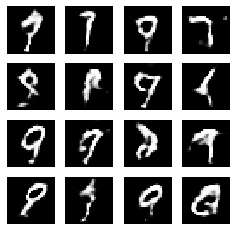

In [12]:
EPOCHS = 50
train(train_dataset, EPOCHS)

# 生成
 不训练，直接使用h5模型生成

In [18]:
# 加载模型

import tensorflow as tf
import matplotlib.pyplot as plt

model = tf.keras.models.load_model('./mnist_dcgan_tf2.h5')

In [ ]:
def generate_and_save_images(model, epoch, test_input):
    # 注意 training` 设定为 False
    # 因此，所有层都在推理模式下运行（batchnorm）
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(4,4))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    plt.savefig('./output/image_at_epoch_{:04d}.png'.format(epoch))
    plt.show()

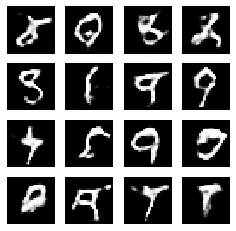

In [16]:
test_input = tf.random.normal([16, 100])
epoch = 10

generate_and_save_images(model, epoch, test_input)